# MNIST handwritten digits

Classifying handwritten digits using a neural network in pytorch.

Referring to the pytorch tutorials at https://pytorch.org/tutorials/beginner/basics/intro.html.

Got to 95% accuarcy without using pooling, normalisation, regularisation, or optimisation algorithms beyond SGD.

Up to 98.6% accuracy now, with batch-norm and dropout seeming to help the most.  Can still try better optimisers and parameter regularisation beyond dropout.

## Getting the data

In [3]:
# Packages and modules
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Functions and classes
from torchvision.transforms import Compose, Normalize, ToTensor, Lambda
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader

In [12]:
# Download and/or load dataset (thanks Yann), and transform to tensors, and one-
# hot encodings
input_transform = Compose([ToTensor(), Normalize(0.5, 0.5)])
target_transform = Lambda(
    lambda y: 
    torch.zeros(10, dtype=torch.float).scatter_(0, torch.tensor(y), value=1)
)
train = MNIST(
    root="data", train=True, transform=input_transform, 
    target_transform=target_transform, download=True
)
test = MNIST(
    root="data", train=False, transform=input_transform, 
    target_transform=target_transform, download=True
)

# Make dataloader
train_dataloader = DataLoader(train, batch_size=3)

# Get first batch of samples and check shape
batch_idx, (example_data, example_targets) = next(enumerate(train_dataloader))
print(example_data.shape)
print(example_targets.shape)

torch.Size([3, 1, 28, 28])
torch.Size([3, 10])


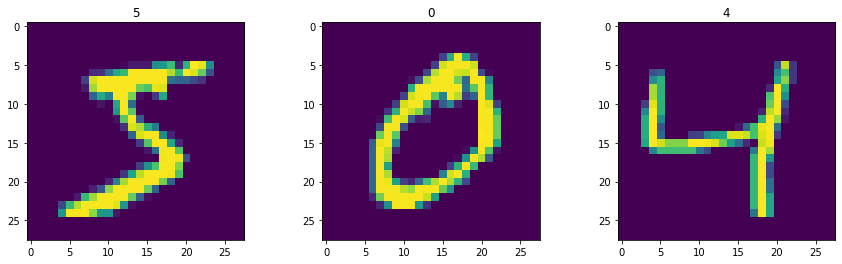

In [13]:
# Show first few inputs and labels
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{example_targets[i].argmax(0)}")
plt.show()

## Convolutional neural network

In [49]:
# Breakdown modelling functions
X = torch.rand(2, 1, 28, 28)
# X = example_data[:1]
print(f"Input: {X.shape}")
X_conv = nn.Conv2d(1, 2, 27)(X)
print(f"Convolved: {X_conv.shape}")
X_pool = nn.MaxPool2d(2)(X_conv)
print(f"Pooled: {X_pool.shape}")
X_flat = nn.Flatten()(X_pool)
print(f"Flattened: {X_flat.shape}")
X_l = nn.Linear(2, 4)(X_flat)
print(f"Linear: {X_l}")
X_batch = nn.BatchNorm1d(num_features=4)(X_l),
print(f"Batchnorm: {X_batch}")
X_r = nn.ReLU()(X_batch[0])
print(f"ReLU: {X_r}")
X_drop = nn.Dropout()(X_r)
print(f"Dropout: {X_drop}")
logits = nn.Linear(4, 4)(X_drop)
print(f"Model: {logits}")
pred_probab = nn.Softmax(dim=1)(logits)
print(f"Probabilities: {pred_probab}")
print(f"Predicted class: {pred_probab.argmax(1)}")

Input: torch.Size([2, 1, 28, 28])
Convolved: torch.Size([2, 2, 2, 2])
Pooled: torch.Size([2, 2, 1, 1])
Flattened: torch.Size([2, 2])
Linear: tensor([[ 0.4595,  0.3458, -0.6157, -0.1866],
        [ 0.4696,  0.3684, -0.7431, -0.2623]], grad_fn=<AddmmBackward0>)
Batchnorm: (tensor([[-0.8481, -0.9628,  0.9988,  0.9965],
        [ 0.8481,  0.9628, -0.9988, -0.9965]],
       grad_fn=<NativeBatchNormBackward0>),)
ReLU: tensor([[0.0000, 0.0000, 0.9988, 0.9965],
        [0.8481, 0.9628, 0.0000, 0.0000]], grad_fn=<ReluBackward0>)
Dropout: tensor([[0.0000, 0.0000, 0.0000, 1.9931],
        [1.6961, 0.0000, 0.0000, 0.0000]], grad_fn=<MulBackward0>)
Model: tensor([[ 0.2827,  0.4515,  1.2267, -0.3784],
        [-0.3372, -0.6575, -0.1264, -0.7627]], grad_fn=<AddmmBackward0>)
Probabilities: tensor([[0.1897, 0.2246, 0.4877, 0.0980],
        [0.2767, 0.2009, 0.3416, 0.1808]], grad_fn=<SoftmaxBackward0>)
Predicted class: tensor([2, 2])


In [15]:
# Create neural network model class
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.seq_modules = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout(),
            nn.BatchNorm2d(num_features=32),
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=4),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Flatten(),
            nn.Dropout(),
            nn.BatchNorm1d(num_features=32*4*4),
            nn.Linear(32*4*4, 10),
        )

    def forward(self, x):
        logits = self.seq_modules(x)
        return logits

## Create model on GPU

In [16]:
# Set device to GPU or CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [17]:
# Create neural network model
conv_model = NeuralNetwork().to(device)
print(conv_model)

NeuralNetwork(
  (seq_modules): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Dropout(p=0.5, inplace=False)
    (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): Conv2d(32, 32, kernel_size=(4, 4), stride=(1, 1))
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Dropout(p=0.5, inplace=False)
    (10): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [18]:
# Use model to get predictions
conv_model(X.to(device))

tensor([[-0.9094,  0.1168,  0.2276,  0.0229, -0.2987,  0.4649,  0.7213, -0.1713,
          0.8408, -1.0028],
        [ 0.9945, -0.1931, -0.2633, -0.0070,  0.2674, -0.5303, -0.6828,  0.1948,
         -0.7733,  1.0725]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [19]:
name, param = next(conv_model.named_parameters())
print(f"Layer: {name}")
print(f"Size: {param.size()}")
print(f"Values : {param[:1]} \n")

Layer: seq_modules.0.weight
Size: torch.Size([32, 1, 5, 5])
Values : tensor([[[[-0.0228,  0.1963, -0.1348, -0.0026,  0.0868],
          [-0.0830, -0.0512,  0.1998, -0.0492, -0.0287],
          [-0.1365, -0.1450, -0.0322,  0.1370, -0.1253],
          [-0.0149,  0.1834,  0.0088, -0.1674,  0.0551],
          [-0.0028, -0.1960,  0.1904, -0.0688,  0.1236]]]], device='cuda:0',
       grad_fn=<SliceBackward0>) 



## Training and testing loops

Pytorch has no model.fit().

In [20]:
# Training and testing functions
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X.to(device))
        loss = loss_fn(pred, y.to(device))

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            y = y.to(device)
            pred = model(X.to(device))
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y.argmax(1)).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    
    return correct

## Find batch size

In [38]:
# Define loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-3)

# Make dataloader
# train_dataloader = DataLoader(train, batch_size=256)

In [22]:
# %%time
# train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 2.488812  [    0/60000]
loss: 2.326731  [ 6400/60000]
loss: 2.076484  [12800/60000]
loss: 2.087468  [19200/60000]
loss: 1.745054  [25600/60000]
loss: 1.746372  [32000/60000]
loss: 1.462981  [38400/60000]
loss: 1.388699  [44800/60000]
loss: 1.369434  [51200/60000]
loss: 1.339909  [57600/60000]
CPU times: user 11.2 s, sys: 65.5 ms, total: 11.3 s
Wall time: 11.7 s


In [25]:
# Make dataloader
# train_dataloader = DataLoader(train, batch_size=512)

In [26]:
# %%time
# train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 0.958613  [    0/60000]
loss: 0.974186  [51200/60000]
CPU times: user 9.55 s, sys: 31.2 ms, total: 9.58 s
Wall time: 9.58 s


In [27]:
# Make dataloader
train_dataloader = DataLoader(train, batch_size=1024)

In [28]:
# %%time
# train_loop(train_dataloader, conv_model, loss_fn, optimizer)

loss: 0.963157  [    0/60000]
CPU times: user 10.2 s, sys: 38.7 ms, total: 10.2 s
Wall time: 10.7 s


## Find learning rate

In [50]:
test_dataloader = DataLoader(test, batch_size=1024)

In [30]:
# conv_model = NeuralNetwork().to(device)
# optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-2)

# train_loop(train_dataloader, conv_model, loss_fn, optimizer)
# correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.479704  [    0/60000]
Test Error: 
 Accuracy: 55.2%, Avg loss: 1.518035 



In [31]:
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e-1)

train_loop(train_dataloader, conv_model, loss_fn, optimizer)
correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.426284  [    0/60000]
Test Error: 
 Accuracy: 90.4%, Avg loss: 0.360441 



In [32]:
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr=1e0)

train_loop(train_dataloader, conv_model, loss_fn, optimizer)
correct = test_loop(test_dataloader, conv_model, loss_fn)

loss: 2.475238  [    0/60000]
Test Error: 
 Accuracy: 96.0%, Avg loss: 0.137014 



## Train model

In [39]:
lr = 2e-1
conv_model = NeuralNetwork().to(device)
optimizer = torch.optim.SGD(conv_model.parameters(), lr)
train_dataloader = DataLoader(train, batch_size=1024, shuffle=True)

In [40]:
last_correct = 0
for t in range(10):
    print(f"Epoch {t+1}\n-------------------------------")
    conv_model.train()
    train_loop(train_dataloader, conv_model, loss_fn, optimizer)
    conv_model.eval()
    correct = test_loop(test_dataloader, conv_model, loss_fn)
    diff = correct - last_correct 
    if diff < 0.01:
        if diff > 0:
            lr /= 2
            optimizer.param_groups[0]['lr'] = lr
            last_correct = correct
        else:
            break
            
print("Done!")

Epoch 1
-------------------------------
loss: 2.445760  [    0/60000]
Test Error: 
 Accuracy: 95.2%, Avg loss: 0.201083 

Epoch 2
-------------------------------
loss: 0.256695  [    0/60000]
Test Error: 
 Accuracy: 97.0%, Avg loss: 0.121209 

Epoch 3
-------------------------------
loss: 0.195291  [    0/60000]
Test Error: 
 Accuracy: 97.4%, Avg loss: 0.097604 

Epoch 4
-------------------------------
loss: 0.164771  [    0/60000]
Test Error: 
 Accuracy: 97.8%, Avg loss: 0.083505 

Epoch 5
-------------------------------
loss: 0.116082  [    0/60000]
Test Error: 
 Accuracy: 98.0%, Avg loss: 0.074605 

Epoch 6
-------------------------------
loss: 0.123895  [    0/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.066087 

Epoch 7
-------------------------------
loss: 0.114076  [    0/60000]
Test Error: 
 Accuracy: 98.2%, Avg loss: 0.062900 

Epoch 8
-------------------------------
loss: 0.128911  [    0/60000]
Test Error: 
 Accuracy: 98.4%, Avg loss: 0.059572 

Epoch 9
----------------

## Check predictions

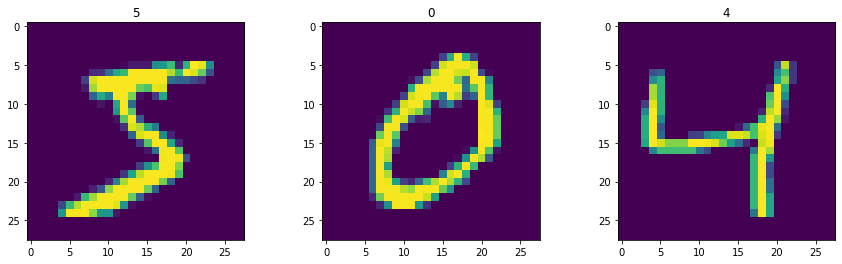

In [35]:
# Show first few sample inputs and predictions
preds = conv_model(example_data[:3].to(device)).argmax(1)
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))
for i in range(3):
    ax = [ax1, ax2, ax3][i]
    ax.imshow(example_data[i][0])
    ax.set_title(f"{preds[i]}")
plt.show()

## Save/load model

In [36]:
# torch.save(conv_model, 'models/conv_mnist')

In [37]:
# conv_model = torch.load('models/conv_mnist')